In [ ]:
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Turlykhan_sentiment_analysis/training.1600000.processed.noemoticon.csv', encoding="ISO-8859-1" , names=["sentiment", "ids", "date", "flag", "user", "text"])

data = data[['sentiment','text']]
data['sentiment'] = data['sentiment'].replace(4,1)

text, sentiment = list(data['text']), list(data['sentiment'])

In [ ]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [ ]:
processedText = []
    
wordLemm = WordNetLemmatizer()
    
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern       = '@[^\s]+'
alphaPattern      = "[^a-zA-Z0-9]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"
    
for tweet in text:
    tweet = tweet.lower()
        
    tweet = re.sub(urlPattern,' URL',tweet)
    for emoji in emojis.keys():
        tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
    tweet = re.sub(userPattern,' USER', tweet)        
    tweet = re.sub(alphaPattern, " ", tweet)
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    tweetwords = ''
    for word in tweet.split():
        if len(word)>1:
            word = wordLemm.lemmatize(word)
            tweetwords += (word+' ')
            
    processedText.append(tweetwords)

print(f'Text Preprocessing complete.')

Text Preprocessing complete.


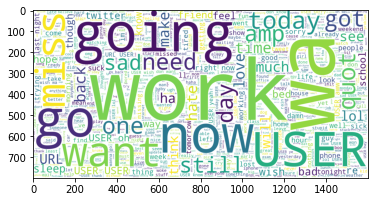

In [ ]:
data_neg = processedText[:800000]
negative_word_cloud = WordCloud(max_words = 1000 , width = 1600 , height = 800, background_color ='white').generate(" ".join(data_neg))
plt.imshow(negative_word_cloud)

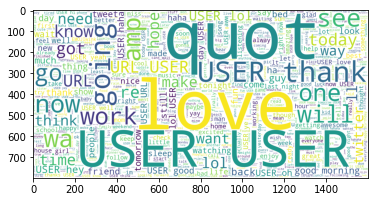

In [ ]:
data_pos = processedText[800000:]
positive_word_cloud = WordCloud(max_words = 1000 , width = 1600 , height = 800, background_color ='white').generate(" ".join(data_pos))
plt.imshow(positive_word_cloud)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processedText, sentiment, test_size = 0.1, random_state = 101)
print(f'Data Split done.')

Data Split done.


In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')

Vectoriser fitted.


In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [ ]:
model = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
model.fit(X_train, y_train)

LogisticRegression(C=2, max_iter=1000, n_jobs=-1)

              precision    recall  f1-score   support

           0       0.83      0.82      0.82     79975
           1       0.82      0.84      0.83     80025

    accuracy                           0.83    160000
   macro avg       0.83      0.83      0.83    160000
weighted avg       0.83      0.83      0.83    160000



Text(0.5, 1.0, 'Confusion Matrix')

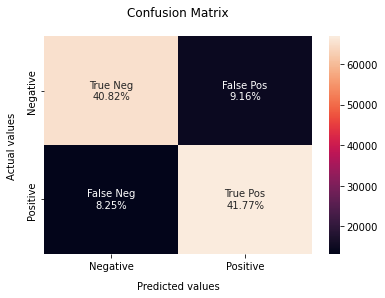

In [ ]:
prediction = model.predict(X_test)

print(classification_report(y_test, prediction))
    
matrix = confusion_matrix(y_test, prediction)

labels = [f'{v1}\n{v2}' for v1, v2 in zip(['True Neg','False Pos', 'False Neg','True Pos'],['{0:.2%}'.format(value) for value in matrix.flatten() / np.sum(matrix)])]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(matrix, annot = labels, fmt = '', xticklabels = ['Negative','Positive'], yticklabels = ['Negative','Positive'])

plt.xlabel("Predicted values", labelpad = 10)
plt.ylabel("Actual values"   , labelpad = 10)
plt.title ("Confusion Matrix", pad = 20)

In [ ]:
file = open('vectoriser.pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('model.pickle','wb')
pickle.dump(model, file)
file.close()